In [1]:
import pandas as pd
from galaxyteam.models.cnn import create_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# pylint: disable=[E0611,E0401]
from tensorflow.keras.layers import (Dense, Dropout, Input)

from tensorflow.keras import callbacks
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow.keras as keras

In [2]:
IMG_SIZE = 224
base_model = ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

In [21]:
### Define F1 measures: F1 = 2 * (precision * recall) / (precision + recall)

def eager_binary_fbeta(ytrue, ypred, beta=1.0, threshold=0.5):
  ypred = np.array(ypred >= threshold, dtype=np.float32)

  return f1_score(ytrue, ypred, beta)

In [3]:
def build_TL():
    
    #Input shape = [width, height, color channels]
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [25]:
keras.backend.clear_session()

model_pretrained = build_TL()
model_pretrained.compile(loss='binary_crossentropy',
                        optimizer = keras.optimizers.Adam(learning_rate=5e-5),
                        metrics=[keras.metrics.Precision(),
                        keras.metrics.Recall()])

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [26]:
#Setting callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [31]:
def train_TL(epochs=1, batch_size=128, val_frac=0.2,
              train_info_file_path='./data/preprocessed/train_metadata.csv'):

    full_train = pd.read_csv(train_info_file_path)

    train_data, val_data = train_test_split(full_train, test_size=0.2,
                                            shuffle=True,
                                            stratify=full_train.is_pneumonia,
                                            random_state=9473)

    # Create Tensorflow datasets
    train_dataset = create_dataset(train_data.resized_file_path,
                                   train_data.is_pneumonia,
                                   batch_size=batch_size)
    val_dataset = create_dataset(val_data.resized_file_path,
                                 val_data.is_pneumonia,
                                 batch_size=batch_size)



    history = model_pretrained.fit(train_dataset,callbacks=[early_stopping, plateau], epochs=epochs, verbose=1,
                        validation_data=val_dataset)

    return history, model_pretrained

In [29]:
history, model = train_TL(batch_size=128)

Epoch 1/10
30/30 [==============================] - 517s 17s/step - loss: 58.4792 - precision: 0.7293 - recall: 0.7838 - val_loss: 38.0558 - val_precision: 0.7247 - val_recall: 1.0000 - lr: 5.0000e-05
Epoch 2/10
 2/30 [=>............................] - ETA: 8:59 - loss: 49.7767 - precision: 0.7261 - recall: 0.9076

KeyboardInterrupt: 

NameError: name 'history' is not defined

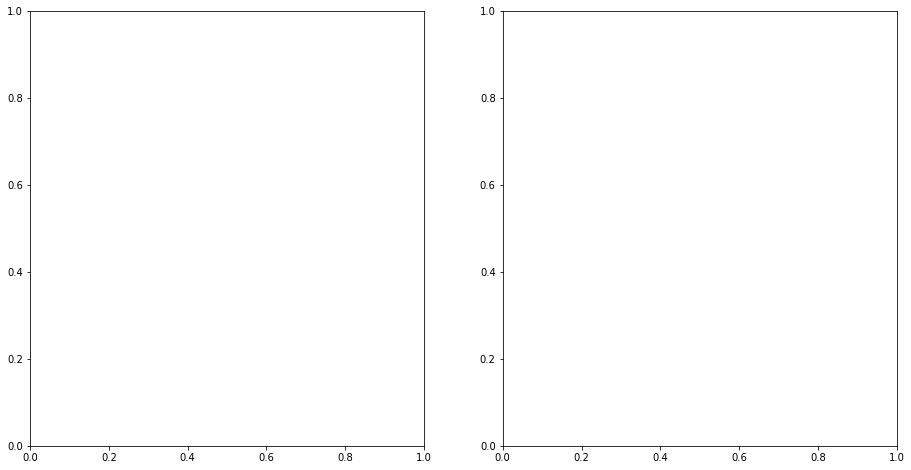

In [30]:
fig = plt.figure(figsize=(24, 8))
sp1 = fig.add_subplot(131)
sp2 = fig.add_subplot(132)

num_epochs = range(0, 15)

sp1.plot(num_epochs, history.history['loss'], linewidth=2, label='Train')
sp1.plot(num_epochs, history.history['val_loss'], linewidth=2, label='Val')

sp2.plot(num_epochs, history.history['binary_accuracy'], linewidth=2, label='Train')
sp2.plot(num_epochs, history.history['val_binary_accuracy'], linewidth=2, label='Val')

sp1.set_xlabel('Epoch')
sp1.set_ylabel('Loss')
sp1.legend()

sp2.set_xlabel('Epoch')
sp2.set_ylabel('binary_accuracy')
sp2.legend()


In [ ]:
model.save('TL_v2')

INFO:tensorflow:Assets written to: TL_v1\assets


INFO:tensorflow:Assets written to: TL_v1\assets


In [20]:
from keras.models import load_model
model = load_model('TL_v1')

In [ ]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=metrics=[keras.metrics.Precision(),
                        keras.metrics.Recall()],
)


In [ ]:
def train_TL_finetune(epochs=10, batch_size=32, val_frac=0.2,
              train_info_file_path='./data/preprocessed/train_metadata.csv'):

    full_train = pd.read_csv(train_info_file_path)

    train_data, val_data = train_test_split(full_train, test_size=0.2,
                                            shuffle=True,
                                            stratify=full_train.is_pneumonia,
                                            random_state=9473)

    # Create Tensorflow datasets
    train_dataset = create_dataset(train_data.resized_file_path,
                                   train_data.is_pneumonia,
                                   batch_size=batch_size)
    val_dataset = create_dataset(val_data.resized_file_path,
                                 val_data.is_pneumonia,
                                 batch_size=batch_size)



    history = model_pretrained.fit(train_dataset,callbacks=[early_stopping, plateau], epochs=epochs, verbose=1,
                        validation_data=val_dataset)

    return history, model_pretrained

In [ ]:
history_ft, model_ft = train_TL_finetune(batch_size=128)

Epoch 1/15
 55/118 [============>.................] - ETA: 3:49 - loss: 44.1372 - binary_accuracy: 0.6261

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(24, 8))
sp1 = fig.add_subplot(131)
sp2 = fig.add_subplot(132)

num_epochs = range(0, 15)

sp1.plot(num_epochs, history_ft.history['loss'], linewidth=2, label='Train')
sp1.plot(num_epochs, history_ft.history['val_loss'], linewidth=2, label='Val')

sp2.plot(num_epochs, history_ft.history['binary_accuracy'], linewidth=2, label='Train')
sp2.plot(num_epochs, history_ft.history['val_binary_accuracy'], linewidth=2, label='Val')

sp1.set_xlabel('Epoch')
sp1.set_ylabel('Loss')
sp1.legend()

sp2.set_xlabel('Epoch')
sp2.set_ylabel('binary_accuracy')
sp2.legend()
